# Simple analysis example of HWP using SO HK data 
SO HK data reading and writing tips: <br>
https://so3g.readthedocs.io/en/latest/hk.html#writing-hk-data

## `update_hwp_angle`
pipeline element to provide HWP angle and approximated speed from SO HK data <br>
https://docs.google.com/document/d/1Hb0LMDB7oUXugeHKqMLOq8EvVijHvPN7ZgB4yZgIEaU/edit?usp=sharing <br>
## `G3tHWP`
class for `update_hwp_angle`

# Download sotodlib hwp branch

In [2]:
!rm -rf sotodlib

In [3]:
!git clone -b hwp https://github.com/simonsobs/sotodlib.git

Cloning into 'sotodlib'...
remote: Enumerating objects: 7589, done.
remote: Counting objects: 100% (214/214), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 7589 (delta 109), reused 172 (delta 92), pack-reused 7375
Receiving objects: 100% (7589/7589), 3.60 MiB | 27.91 MiB/s, done.
Resolving deltas: 100% (5511/5511), done.


## Run as script

In [4]:
!cp sotodlib/sotodlib/site_pipeline/update_hwp_angle.py sotodlib/

In [5]:
!python sotodlib/update_hwp_angle.py -h

   0.000: update-hwp-angle: Log timestamps are relative to 2022-11-08 01:26:42,816 (INFO)
usage: update_hwp_angle.py [-h] -c CONFIG_FILE [-d DATA_DIR] [-o OUTPUT_DIR]
                           [--update-delay UPDATE_DELAY] [--file FILE]
                           [--verbose VERBOSE]

Analyze HWP encoder data from level-2 HK data, and produce HWP angle solution
for all times.

optional arguments:
  -h, --help            show this help message and exit
  -c CONFIG_FILE, --config-file CONFIG_FILE
                        Configuration File for running update_hwp_angle
  -d DATA_DIR, --data-dir DATA_DIR
                        input data directory, overwrite config data_dir
  -o OUTPUT_DIR, --output-dir OUTPUT_DIR
                        output data directory, overwrite config output_dir
  --update-delay UPDATE_DELAY
                        Days to subtract from now to set as minimum ctime. Set
                        to 0 to build from scratch
  --file FILE           Force processing of a

## Run with days to subtract from now

In [ ]:
!python sotodlib/update_hwp_angle.py -c update_hwp_config.yaml --update-delay 7

## Run with specific g3 file

In [9]:
!python sotodlib/update_hwp_angle.py -c update_hwp_config.yaml --file /mnt/so1/data/ucsd-sat1/hk/16675/1667556546.g3

   0.000: update-hwp-angle: Log timestamps are relative to 2022-11-08 01:30:09,137 (INFO)
   0.001: Starting update_hwp_angle (INFO)
   7.129: Processing /mnt/so1/data/ucsd-sat1/hk/16675/1667556546.g3 (INFO)
  32.790: writing solution /mnt/so1/users/ysakurai/sotodlib_dev/hwp/output/16675/1667556546.g3 (INFO)


## Import libraries
Import SO related libraries: so3g, update_hwp_angle <br>
If you see any error after this, check the name of kernel. 

In [10]:
import sys
import os
sys.path.insert(0, os.getcwd()+ "/sotodlib")

import numpy as np
import datetime as dt
import time as tm
import scipy.interpolate
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy as sp
import glob
import logging

import so3g
import sotodlib
from sotodlib import core, tod_ops, sim_flags, flags, hwp
from sotodlib.io.load_smurf import load_file
from sotodlib.tod_ops import fourier_filter, rfft, detrend_tod
import sotodlib.tod_ops.filters as filters

## Load SO HK data with config file

- Please prepare and use config yaml file to load HWP hardware info.<br>
- But it works without a config file using default values for convenience.<br>
- You can find example yaml file in simons1:/mnt/so1/users/ysakurai/hwp_configs/hwp_config.yaml

### config.yaml file example

In [11]:
hwp_angle_tool = hwp.G3tHWP('update_hwp_config.yaml')
data = hwp_angle_tool.load_file("/mnt/so1/data/ucsd-sat1/hk/16675/1667556546.g3")
solved = hwp_angle_tool.analyze(data)

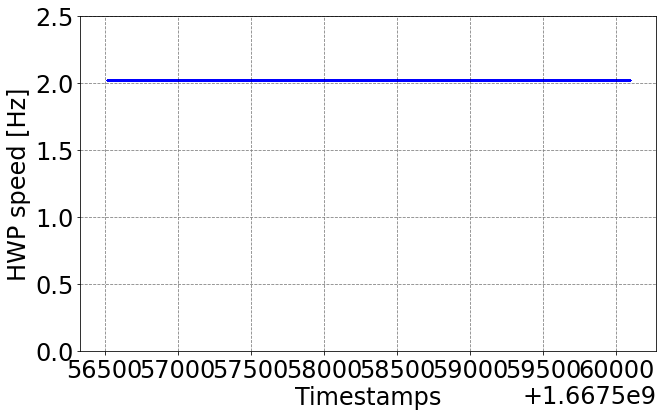

In [18]:
plt.figure(figsize=(10,6))
plt.xlabel('Timestamps')
plt.ylabel('HWP speed [Hz]')
idx = np.where(solved['locked'])
plt.plot(solved['slow_time'][idx],solved['hwp_rate'][idx],'.b', markersize=0.1)
plt.ylim(0,2.5)
plt.show()

## Load SO HK data with arguments

In [8]:
start, end = 1643340368.424739, 1643340969.269591 #spinup data from TSAT (Pton)
data_dir = '/mnt/so1/data/pton-tsat/hk/' # path to HK data archive
data_spinup = hwp_angle_tool.load_data(start=start, end=end, data_dir=data_dir, instance='HBA1') # instance is 'HBA1' in TSAT case 

In [9]:
start, end = 1643342329, 1643342929 # 2Hz rotation data from TSAT (Pton)
data_dir = '/mnt/so1/data/pton-tsat/hk/' # path to HK data archive
data_rot = hwp_angle_tool.load_data(start=start, end=end, data_dir=data_dir, instance='HBA1') # instance is 'HBA1' in TSAT case 

## Analyze loaded HWP parameters and return angles
Return  dict{fast_time, angle, slow_time, stable, locked, hwp_rate}
* fast_time: IRIG synched timing (~2kHz) 
* angle (float): IRIG synched HWP angle in radian
* slow_time: time list of slow block
* stable (flag): if non-zero, indicates the HWP spin state is known. i.e. it is either spinning at a measurable rate, or stationary.  When this flag is non-zero, the hwp_rate field can be taken at face value.
* locked (flag): if non-zero, indicates the HWP is spinning and the position solution is working. 
* hwp_rate (float): the "approximate" HWP spin rate, with sign, in revs / second.  Use placeholder value of 0 for cases when not "stable".

In [10]:
solved_spinup = hwp_angle_tool.analyze(data_spinup)

In [11]:
solved_rot = hwp_angle_tool.analyze(data_rot)

## Load SO HK data with g3 file name 

In [12]:
import sys
sys.path.insert(0,"/homes/ysakurai/analysis/sotodlib_dev/sotodlib/")
print(sys.path)
from sotodlib import hwp

['/homes/ysakurai/analysis/sotodlib_dev/sotodlib/', '/mnt/so1/users/ysakurai/work/so_pwg_tutorial/sotodlib', '/mnt/so1/users/ysakurai/work/so_pwg_tutorial', '', '/mnt/so1/shared/software/so_pysm_models/201029/lib/python3.7/site-packages', '/mnt/so1/shared/software/pixell/220816/lib/python3.7/site-packages', '/mnt/so1/shared/software/sotodlib/220113/lib/python3.7/site-packages', '/mnt/so1/shared/software/so3g/220103/lib/python3.7/site-packages', '/mnt/so1/shared/software/spt3g_software/210824/lib/python3.7/site-packages', '/mnt/so1/shared/software/qpoint/1.11.1/lib/python3.7/site-packages', '/mnt/so1/shared/software/libmadam/1.0.2/lib/python3.7/site-packages', '/mnt/so1/shared/software/mpi4py_mpich/200627/lib/python3.7/site-packages', '/mnt/so1/shared/software/toast_2.3/210824/lib/python3.7/site-packages', '/mnt/so1/shared/software/anaconda3/200627/lib/python37.zip', '/mnt/so1/shared/software/anaconda3/200627/lib/python3.7', '/mnt/so1/shared/software/anaconda3/200627/lib/python3.7/lib-d

In [13]:
hwp_angle_tool = hwp.G3tHWP('hwp_config.yaml')

In [14]:
data_file = hwp_angle_tool.load_file()
solved_file = hwp_angle_tool.analyze(data_file)

In [15]:
print(solved_file['hwp_rate'][np.where(solved_file['locked'])])

[1.49332786 1.49332786 1.49332786 ... 0.18508578 0.18508578 0.18508578]


## Plot hwp speed & angle

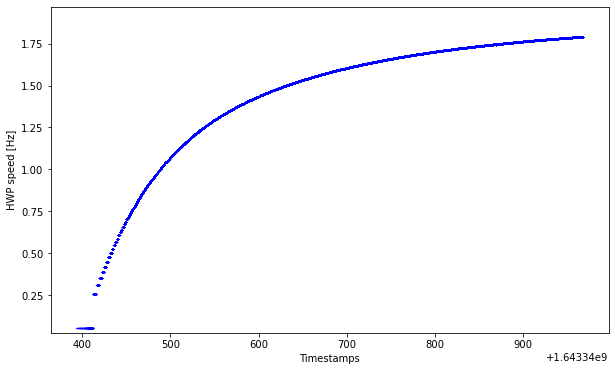

In [16]:
plt.figure(figsize=(10,6))
plt.xlabel('Timestamps')
plt.ylabel('HWP speed [Hz]')
idx = np.where(solved_spinup['locked'])
plt.plot(solved_spinup['slow_time'][idx],solved_spinup['hwp_rate'][idx],'.b', markersize=0.1)

plt.ylim(solved_spinup['hwp_rate'][idx].min()*0.5,solved_spinup['hwp_rate'][idx].max()*1.1)
plt.show()

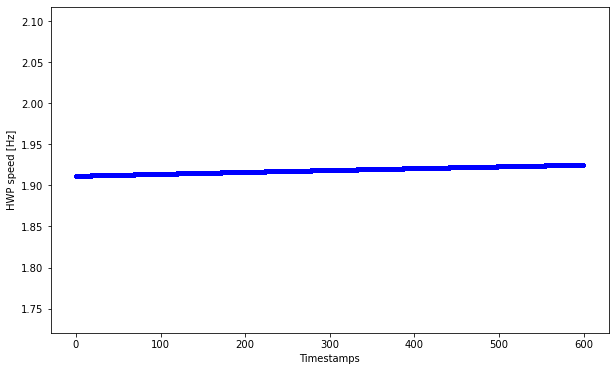

In [17]:
plt.figure(figsize=(10,6))
plt.xlabel('Timestamps')
plt.ylabel('HWP speed [Hz]')
idx = np.where(solved_rot['locked'])
#plt.plot(solved_rot['slow_time'][idx],solved_rot['hwp_rate'][idx],'.', markersize=0.1)
plt.plot(solved_rot['slow_time'][idx] - solved_rot['slow_time'][idx][0], solved_rot['hwp_rate'][idx],".b")
plt.ylim(solved_rot['hwp_rate'][idx].min()*0.9,solved_rot['hwp_rate'][idx].max()*1.1)
plt.show()

In [18]:
def fit_hwp_speed(x,a,b,c,d):
    return a*np.exp(-b*x + c) + d

In [19]:
init = [-6e-2,  2e-4,  5e-1,  2.0]
popt, pcov = sp.optimize.curve_fit(fit_hwp_speed, solved_rot['slow_time'][idx] - solved_rot['slow_time'][idx][0], solved_rot['hwp_rate'][idx], p0=init, maxfev = 10000)

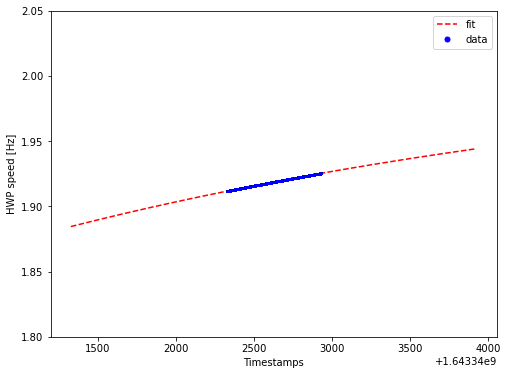

In [20]:
plt_time = np.arange(solved_rot['slow_time'][idx][0]-1000,solved_rot['slow_time'][idx][-1]+1000,0.1)
plt.figure(figsize=(8,6))
plt.xlabel('Timestamps')
plt.ylabel('HWP speed [Hz]')
idx = np.where(solved_rot['locked'])
plt.plot(plt_time,fit_hwp_speed(plt_time - solved_rot['slow_time'][idx][0], *popt),'--r',label='fit')
plt.plot(solved_rot['slow_time'][idx],solved_rot['hwp_rate'][idx],'.b', markersize=1,label='data')
plt.ylim(1.8,2.05)
plt.legend(markerscale=10)
plt.show()

In [21]:
print(solved_rot)

{'fast_time': array([1.64334233e+09, 1.64334233e+09, 1.64334233e+09, ...,
       1.64334293e+09, 1.64334293e+09, 1.64334293e+09]), 'angle': array([0.65587636, 0.66138793, 0.66689949, ..., 1.67551608, 1.68102765,
       1.68653921]), 'slow_time': array([1.64334233e+09, 1.64334233e+09, 1.64334233e+09, ...,
       1.64334293e+09, 1.64334293e+09, 1.64334293e+09]), 'stable': array([ True,  True,  True, ...,  True,  True,  True]), 'locked': array([False, False, False, ..., False, False, False]), 'hwp_rate': array([0., 0., 0., ..., 0., 0., 0.])}


In [22]:
np.argwhere(solved_rot['locked']).flatten()
(solved_rot['fast_time'])[idx]

array([1.64334233e+09, 1.64334233e+09, 1.64334233e+09, ...,
       1.64334293e+09, 1.64334293e+09, 1.64334293e+09])

In [23]:
idx = np.argwhere(solved_rot['locked']).flatten()
len(idx),len(solved_rot['fast_time'])

(1311000, 1312328)

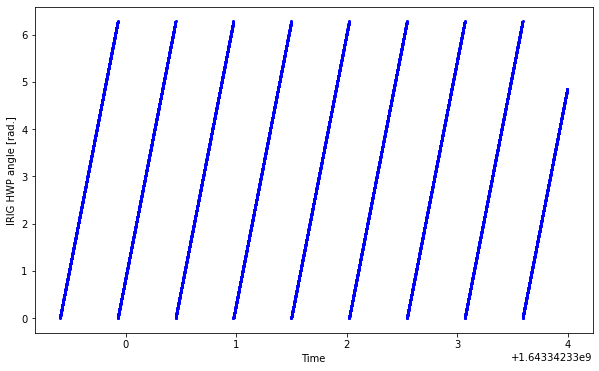

In [24]:
n = 10000
plt.figure(figsize=(10,6))
plt.xlabel('Time')
plt.ylabel('IRIG HWP angle [rad.]')
idx = np.argwhere(solved_rot['locked']).flatten()
plt.plot(solved_rot['fast_time'][idx][:n], solved_rot['angle'][idx][:n], '.b',markersize=4)
plt.show()

### Output HWP angle g3 file with SO HK data format (optional)

In [25]:
hwp_angle_tool.write_solution(solved_rot,'output.g3') # you can also write output path+filename in config file

### Laod output angle g3 file

In [26]:
scanner = so3g.hk.HKArchiveScanner()
filename = 'output.g3'
scanner.process_file(filename)
arc = scanner.finalize()
print(arc.get_data()[0].keys())

dict_keys(['hwp.hwp_rate', 'hwp.locked', 'hwp.stable', 'hwp.hwp_angle'])


In [27]:
fields = ['hwp.hwp_angle', 'hwp.locked', 'hwp.stable','hwp.hwp_rate']

In [28]:
output_data = arc.simple(fields)
fast_time = output_data[0][0]
angle = output_data[0][1]
slow_time = output_data[1][0]
locked = output_data[1][1]
stable = output_data[2][1]
hwp_rate = output_data[3][1]

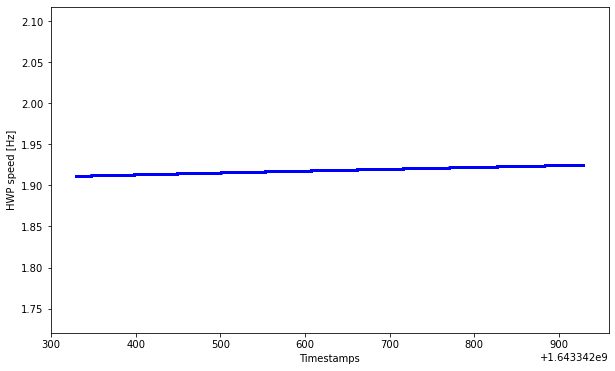

In [29]:
plt.figure(figsize=(10,6))
plt.xlabel('Timestamps')
plt.ylabel('HWP speed [Hz]')
idx = np.where(solved_rot['locked'])
plt.plot(slow_time[idx],hwp_rate[idx],'.b',markersize=1)
plt.ylim(hwp_rate[idx].min()*0.9,hwp_rate[idx].max()*1.1)
plt.show()

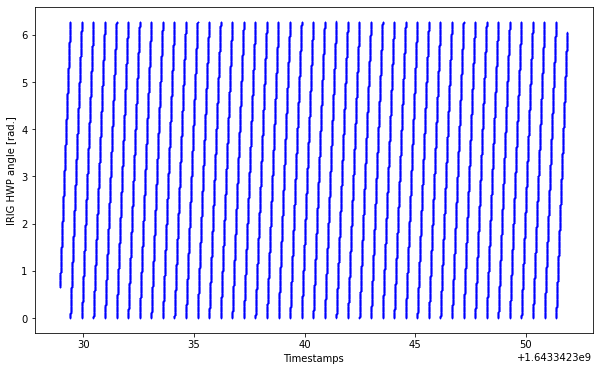

In [30]:
n = 50000
plt.figure(figsize=(10,6))
plt.xlabel('Timestamps')
plt.ylabel('IRIG HWP angle [rad.]')
idx = np.where(solved_rot['locked'])
plt.plot(output_data[0][0][:n],output_data[0][1][:n],'.b',markersize=1)
plt.show()

## Example of detector timestream + HWP analysis

### load timestream

**HWP spinning at around 2Hz** <br>
/pton-rd/timestreams/16433/crate1slot4/1643342329_000.g3 <br>
/pton-rd/timestreams/16433/crate1slot4/1643342329_001.g3

In [31]:
#archive_path = '/path/to/data/timestream/'
archive_path = '/mnt/so1/data/pton-rd/timestreams/16433/crate1slot4'
aman_tsat = load_file([   
    archive_path + '/1643342329_000.g3',
    archive_path + '/1643342329_001.g3',
])

100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


In [32]:
phase_to_pA = 9e6/(2*np.pi) #design value of uMUX calculated from mutual inductance of TES and SQUID loop
aman_tsat.signal *= phase_to_pA

### Llinear interpolation between IRIG and SMuRF timing

In [33]:
import scipy
hwp_angle_tsat = scipy.interpolate.interp1d(solved_rot['fast_time'], solved_rot['angle'], kind='linear',fill_value='extrapolate')(aman_tsat.timestamps) % (2*np.pi)

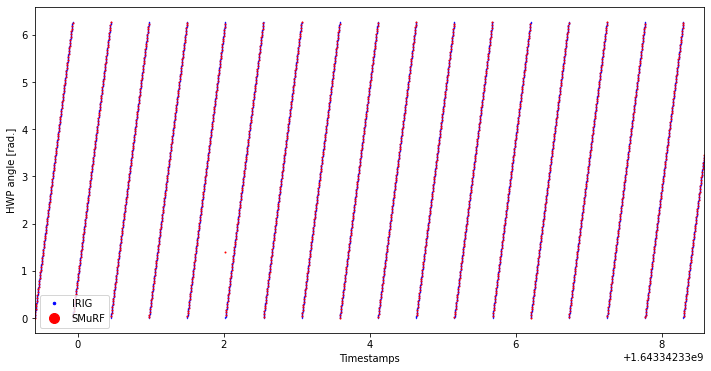

In [34]:
s = 0; e = 20000
plt.figure(figsize=(12,6), facecolor='w')
plt.xlabel('Timestamps')
plt.ylabel('HWP angle [rad.]')
idx = np.where(solved_rot['locked'])
plt.plot(solved_rot['fast_time'][idx], solved_rot['angle'][idx], '.b',markersize=0.5, label='IRIG')
plt.plot(aman_tsat.timestamps, hwp_angle_tsat, '.r', markersize=2, label ='SMuRF')
plt.xlim(solved_rot['fast_time'][idx][s],solved_rot['fast_time'][idx][e])
#plt.ylim(0,5)
plt.legend(loc=0,markerscale=10)
plt.show()

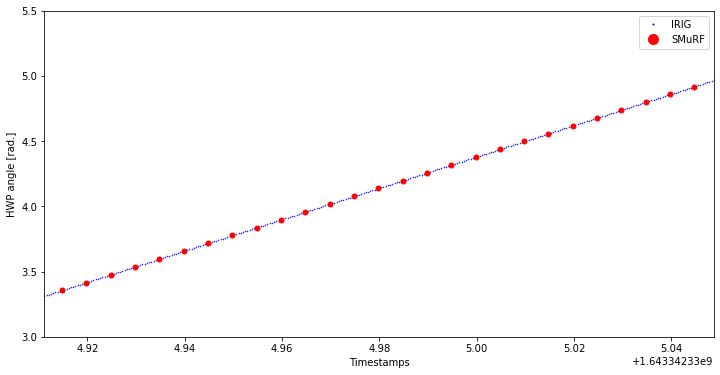

In [35]:
n = 12300
plt.figure(figsize=(12,6), facecolor='w')
plt.xlabel('Timestamps')
plt.ylabel('HWP angle [rad.]')
idx = np.where(solved_rot['locked'])
plt.plot(solved_rot['fast_time'][idx], solved_rot['angle'][idx], '.b',markersize=1, label='IRIG')
plt.plot(aman_tsat.timestamps, hwp_angle_tsat, '.r', markersize=10, label ='SMuRF')
plt.xlim(solved_rot['fast_time'][idx][12000],solved_rot['fast_time'][idx][n])
plt.ylim(3,5.5)
plt.legend(loc=0,markerscale=2)
plt.show()

# HWP Syncrhnous Signal Simulation and Subtraction

## HWPSS simulation

In [36]:
sampling_rate = 200 #Hz
obs_time = 6000 #s = 10min
n_ch = 10 # number of bolos.
dets_name = ['det' + str(i+1) for i in range(n_ch)] # detector name
aman_sim = core.AxisManager(core.LabelAxis('dets', dets_name), core.OffsetAxis('samps', obs_time*sampling_rate),) # AxisManager

### White noise

In [37]:
rng = np.random.default_rng()
if not 'timestamps' in aman_sim.keys(): aman_sim.wrap('timestamps', (1/sampling_rate)*np.arange(aman_sim.samps.count), [(0,'samps')] )
white_noise_level = 0.270 *np.sqrt(2) ## mK_RJ / rt. Hz for MF2 detectors
if not 'noise' in aman_sim.keys(): aman_sim.wrap('noise', rng.normal(scale=np.sqrt(white_noise_level**2*sampling_rate / 2), size=(aman_sim.dets.count, aman_sim.samps.count)), [(0,'dets'), (1,'samps')])

### 1/f noise

In [38]:
f_knee = 0.2 # Hz
alpha = -1.5
fs = np.median(np.diff(aman_sim.timestamps))
freqs = np.fft.fftfreq( aman_sim.samps.count, fs)
one_over_f = (white_noise_level*(np.abs(freqs) / f_knee)**alpha) * np.exp(1.0j*np.mod(np.random.uniform(2*np.pi, size=(aman_sim.dets.count, aman_sim.samps.count)), 1*np.pi))
one_over_f[:,0] = 0
one_over_f *= np.sqrt( fs * aman_sim.samps.count**2 / 2)
if not 'one_over_f' in aman_sim.keys(): aman_sim.wrap('one_over_f', np.real(np.fft.ifft( one_over_f )), [(0,'dets'), (1,'samps')])
else: aman_sim.one_over_f = np.real(np.fft.ifft( one_over_f ))

/mnt/so1/shared/software/anaconda3/200627/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


In [39]:
if not 'flags' in aman_sim.keys(): aman_sim.wrap('flags', core.FlagManager.for_tod(aman_sim))
else: aman_sim.flags = core.FlagManager.for_tod(aman)

In [40]:
if not 'signal_one_over_f' in aman_sim.keys(): aman_sim.wrap('signal_one_over_f', aman_sim.noise+aman_sim.one_over_f, [(0,'dets'), (1,'samps')] )
else: aman_sim.signal_one_over_f = aman_sim.noise+aman_sim.one_over_f

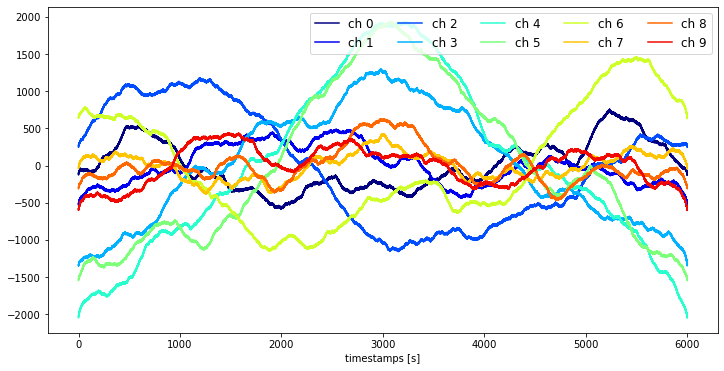

In [41]:
plt.figure(figsize=(12,6), facecolor='w')
for i in range(aman_sim.dets.count): plt.plot(aman_sim.timestamps,aman_sim.signal_one_over_f[i],color=cm.jet(i/aman_sim.dets.count),label='ch '+str(i))
plt.xlabel('timestamps [s]')
plt.legend(loc=1,ncol=5,fontsize=12)
plt.show()

## Glitches

In [42]:
if 'glitch_large' in aman_sim.keys(): aman_sim.glitch_large[:,None] = 0
if 'glitch_small' in aman_sim.keys(): aman_sim.glitch_small[:,None] = 0
sim_flags.add_random_glitches( aman_sim, params={'n_glitches': 10, 'sig_n_glitch': 10, 'h_glitch':100, 'sig_h_glitch':300}, signal='glitch_large', overwrite=True)
sim_flags.add_random_glitches( aman_sim, params={'n_glitches': 50, 'sig_n_glitch': 50, 'h_glitch':10, 'sig_h_glitch':5}, signal='glitch_small', overwrite=True)

In [43]:
if not 'signal_dets' in aman_sim.keys(): aman_sim.wrap('signal_dets', aman_sim.noise + aman_sim.glitch_large + aman_sim.glitch_small, [(0,'dets'), (1,'samps')] )
else: aman_sim.signal_dets = aman_sim.noise + aman_sim.glitch_large + aman_sim.glitch_small
aman_sim.signal_one_over_f = aman_sim.one_over_f + aman_sim.signal_dets

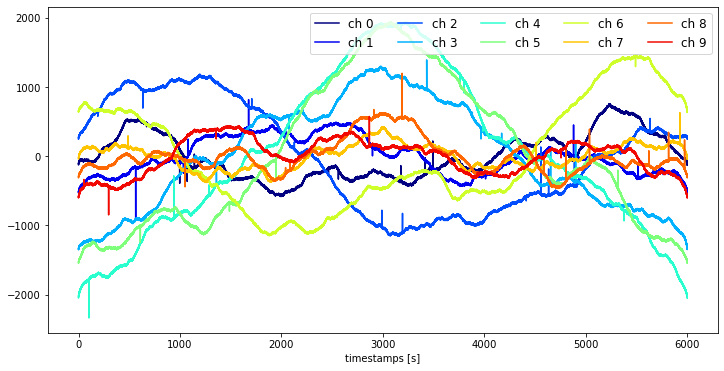

In [44]:
plt.figure(figsize=(12,6), facecolor='w')
for i in range(aman_sim.dets.count): plt.plot(aman_sim.timestamps,aman_sim.signal_one_over_f[i],color=cm.jet(i/aman_sim.dets.count),label='ch '+str(i))
plt.xlabel('timestamps [s]')
plt.legend(loc=1,ncol=5,fontsize=12)
plt.show()

## Save AxisManager

In [45]:
aman_sim.save('tutorial_hwp.h5', 'aman_sim', overwrite=True)

## Load AxisManager

In [3]:
aman_sim = core.AxisManager.load('tutorial_hwp.h5', 'aman_sim')

In [4]:
aman_sim

AxisManager(timestamps[samps], noise[dets,samps], one_over_f[dets,samps], flags*[dets,samps], signal_one_over_f[dets,samps], glitch_large[dets,samps], glitch_small[dets,samps], signal_dets[dets,samps], dets:LabelAxis(10), samps:OffsetAxis(1200000))

## Simulate HWPSS TOD

In [5]:
hwp_freq = 2.0
hwp.sim_hwpss_2f4f(aman_sim, name='hwpss_sim', hwp_freq=hwp_freq, amp_2f=300, amp_4f=10, phi_2f=0, phi_4f=0, amp_2f_r=0, amp_4f_r=0, phi_2f_r=0, phi_4f_r=0)

In [6]:
if 'signal_hwpss' in aman_sim.keys(): aman_sim.move('signal_hwpss','')
aman_sim.wrap('signal_hwpss', aman_sim.signal_one_over_f+aman_sim.hwpss_sim, [(0,'dets'), (1,'samps')] )

AxisManager(timestamps[samps], noise[dets,samps], one_over_f[dets,samps], flags*[dets,samps], signal_one_over_f[dets,samps], glitch_large[dets,samps], glitch_small[dets,samps], signal_dets[dets,samps], hwpss_sim[dets,samps], hwp_angle[samps], signal_hwpss[dets,samps], dets:LabelAxis(10), samps:OffsetAxis(1200000))

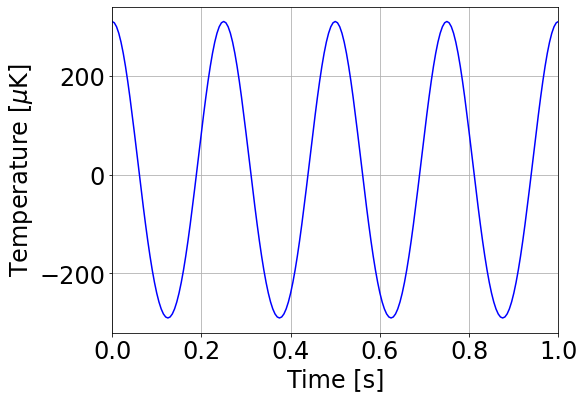

In [58]:
plt.figure(figsize=(8,6), facecolor='w')
#for i in range(aman_sim.dets.count): 
plt.plot(aman_sim.timestamps,aman_sim.hwpss_sim[i],color="b",label='ch '+str(0))
plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
plt.xlim(0,1)
plt.xlabel('Time [s]', fontsize=24)
plt.ylabel(r'Temperature [$\mu$K]', fontsize=24)
plt.grid(True)
plt.show()

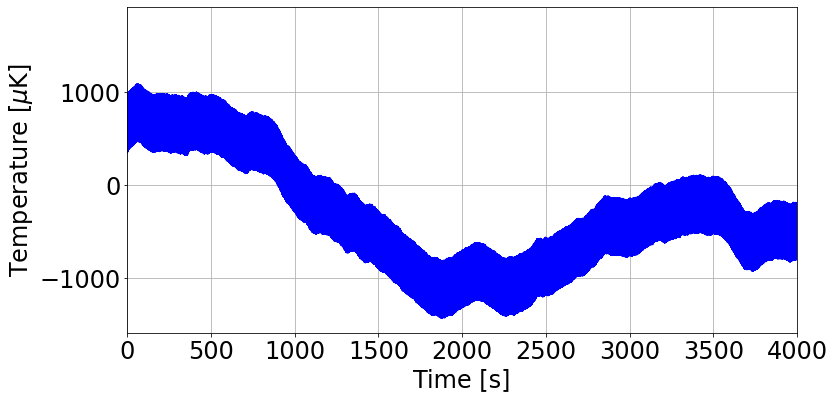

In [56]:
import matplotlib as mpl
label_size = 24
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
plt.figure(figsize=(12,6), facecolor='w')
#for i in range(aman_sim.dets.count): plt.plot(aman_sim.timestamps,aman_sim.signal_hwpss[i],color=cm.jet(i/aman_sim.dets.count),label='ch '+str(i))
plt.plot(aman_sim.timestamps,aman_sim.signal_hwpss[6],color="b",label='')
plt.xlabel('Time [s]', fontsize=24)
plt.ylabel(r'Temperature [$\mu$K]', fontsize=24)
plt.grid(True)
plt.xlim(0,4000)
#plt.legend(loc=1, ncol=5,fontsize=12)
plt.show()

In [52]:
if 'signal_hwpss_prefilt' in aman_sim.keys(): aman_sim.move('signal_hwpss_prefilt','')
aman_sim.wrap_new('signal_hwpss_prefilt', ('dets', 'samps'))
filt = tod_ops.filters.high_pass_sine2(cutoff=1)
prefilt = tod_ops.fourier_filter(aman_sim, filt, detrend=None, signal_name='signal_hwpss')
aman_sim.signal_hwpss_prefilt = np.array(prefilt)

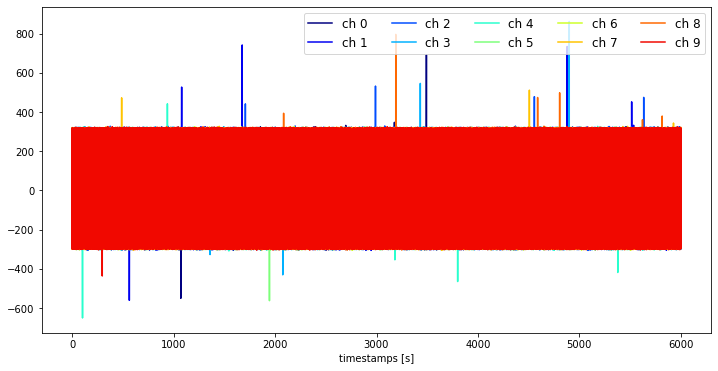

In [53]:
plt.figure(figsize=(12,6), facecolor='w')
for i in range(aman_sim.dets.count): plt.plot(aman_sim.timestamps,aman_sim.signal_hwpss_prefilt[i],color=cm.jet(i/aman_sim.dets.count),label='ch '+str(i))
plt.xlabel('timestamps [s]')
plt.legend(loc=1, ncol=5,fontsize=12)
plt.show()

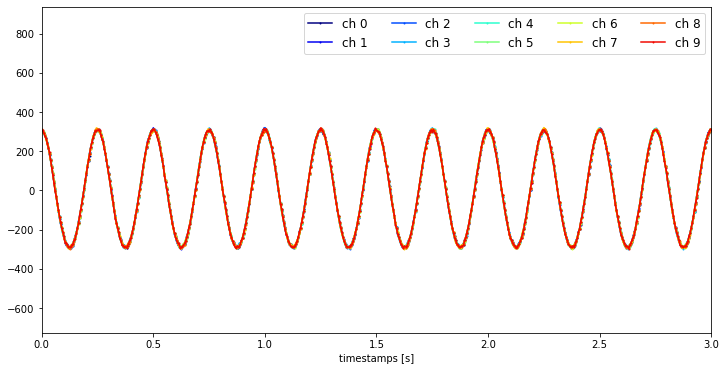

In [54]:
plt.figure(figsize=(12,6), facecolor='w')
#for i in range(aman_sim.dets.count): 
for i in range(aman_sim.dets.count): plt.plot(aman_sim.timestamps,aman_sim.signal_hwpss_prefilt[i],'.-',color=cm.jet(i/aman_sim.dets.count),markersize=2,label='ch '+str(i))
plt.xlim(0,3)
#plt.ylim(-200,200)
plt.xlabel('timestamps [s]')
plt.legend(loc=1, ncol=5,fontsize=12)
plt.show()

## Extract HWPSS from simulated TOD

In [55]:
hwp.extract_hwpss(aman_sim,mode=0,name='hwpss_ext',signal='signal_hwpss_prefilt',bins=36001)

In [56]:
if 'signal_hwpss_subtract' in aman_sim.keys(): aman_sim.move('signal_hwpss_subtract','')
aman_sim.wrap('signal_hwpss_subtract', aman_sim.signal_hwpss-aman_sim.hwpss_ext, [(0,'dets'), (1,'samps')] )
if 'signal_hwpss_subtract_prefilt' in aman_sim.keys(): aman_sim.move('signal_hwpss_subtract_prefilt','')
aman_sim.wrap('signal_hwpss_subtract_prefilt', aman_sim.signal_hwpss_prefilt-aman_sim.hwpss_ext, [(0,'dets'), (1,'samps')] )

AxisManager(timestamps[samps], noise[dets,samps], one_over_f[dets,samps], flags*[dets,samps], signal_one_over_f[dets,samps], glitch_large[dets,samps], glitch_small[dets,samps], signal_dets[dets,samps], hwpss_sim[dets,samps], hwp_angle[samps], signal_hwpss[dets,samps], signal_hwpss_prefilt[dets,samps], hwpss_ext[dets,samps], signal_hwpss_subtract[dets,samps], signal_hwpss_subtract_prefilt[dets,samps], dets:LabelAxis(10), samps:OffsetAxis(1200000))

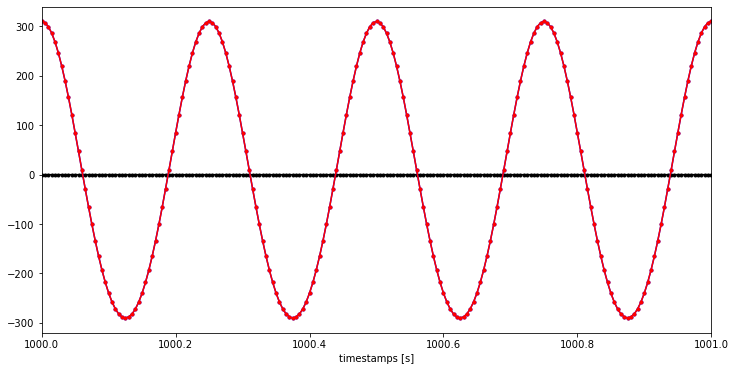

In [57]:
ch = 5
plt.figure(figsize=(12,6))
plt.plot(aman_sim.timestamps, aman_sim.hwpss_sim[ch] - aman_sim.hwpss_ext[ch],'.-',color='k')
plt.plot(aman_sim.timestamps, aman_sim.hwpss_sim[ch],'.-',color='b')
plt.plot(aman_sim.timestamps, aman_sim.hwpss_ext[ch],'.-',color='r')
plt.xlabel('timestamps [s]')
plt.xlim(1000,1001)
plt.show()

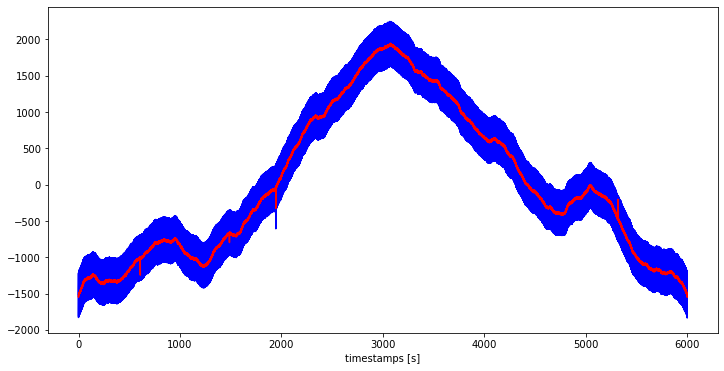

In [58]:
ch = 5
plt.figure(figsize=(12,6))
plt.plot(aman_sim.timestamps, aman_sim.signal_hwpss[ch],color='b')
plt.plot(aman_sim.timestamps, aman_sim.signal_hwpss_subtract[ch],color='r')
plt.xlabel('timestamps [s]')
#plt.xlim(1000,1010)
plt.show()

In [59]:
ffts_b, freqs_b = rfft(aman_sim, resize=None, signal_name='signal_hwpss')
ffts_a, freqs_a = rfft(aman_sim, resize=None, signal_name='signal_hwpss_subtract')
tsamp = np.median(np.diff(aman_sim.timestamps))
norm_fact =  np.sqrt(2)*(1.0/tsamp)*np.sum(np.abs(np.hanning(aman_sim.samps.count))**2)

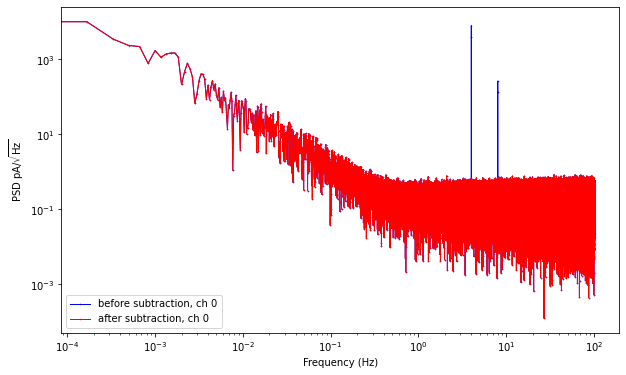

In [60]:
fig = plt.figure(figsize=(10,6))
plt.ylabel('PSD $\mathrm{pA / \sqrt{Hz}}$')
plt.xlabel('Frequency (Hz)')

for i in [0]:
    psd_b = np.sqrt(np.abs(ffts_b[i])**2/norm_fact)
    plt.loglog(freqs_b, psd_b, '.-', markersize=1, color='b',lw=1, label='before subtraction, ch ' + str(i))
for i in [0]:
    psd_a = np.sqrt(np.abs(ffts_a[i])**2/norm_fact)
    plt.loglog(freqs_a, psd_a, '.-', markersize=1, color='r',lw=1, label='after subtraction, ch ' + str(i))
plt.legend()
plt.show()

# Demodulation of Simulated TODs

In [61]:
hwp.demod(aman_sim,bpf_width=0.1,lpf_cut=1,signal='signal_hwpss')

In [62]:
ffts_b, freqs_b = rfft(aman_sim, resize=None, signal_name='signal_hwpss_subtract')
ffts_a, freqs_a = rfft(aman_sim, resize=None, signal_name='signal_demod')
tsamp = np.median(np.diff(aman_sim.timestamps))
norm_fact =  np.sqrt(2)*(1.0/tsamp)*np.sum(np.abs(np.hanning(aman_sim.samps.count))**2)
mask_lpf = np.where(freqs_a<1)

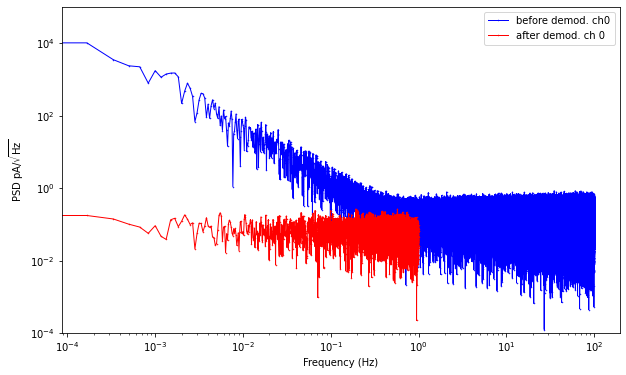

In [63]:
fig = plt.figure(figsize=(10,6))
plt.ylabel('PSD $\mathrm{pA / \sqrt{Hz}}$')
plt.xlabel('Frequency (Hz)')
for i in [0]:
    psd_b = np.sqrt(np.abs(ffts_b[i])**2/norm_fact)
    plt.loglog(freqs_b, psd_b, '.-', markersize=1, color='b',lw=1, label='before demod. ch' + str(i))
for i in [0]:
    psd_a = np.sqrt(np.abs(ffts_a[i])**2/norm_fact)
    plt.loglog(freqs_a[mask_lpf], psd_a[mask_lpf], '.-', markersize=1, color='r',lw=1, label='after demod. ch ' + str(i))
plt.legend()
plt.ylim(1e-4,1e5)
plt.show()

# HWP Analysis using TSAT data

## HWPSS

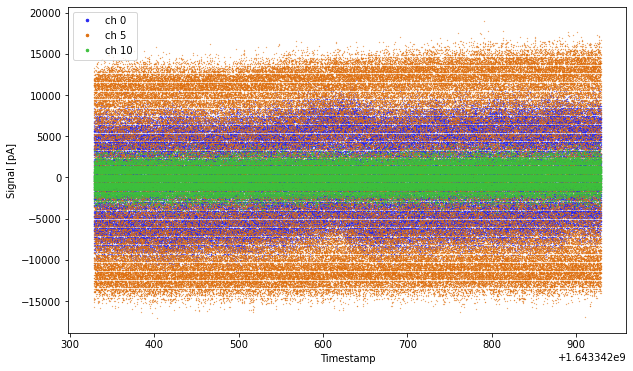

In [64]:
plt.figure(figsize=(10,6))
plt.xlabel('Timestamp')
plt.ylabel('Signal [pA]')
for i in [0,5,10]:
    plt.plot(aman_tsat.timestamps,aman_tsat.signal[i] - aman_tsat.signal[i].mean(),".", markersize=0.5, label='ch ' + str(i))
plt.legend(markerscale=10)
plt.show()

In [65]:
ffts, freqs = rfft(aman_tsat, resize=None)
tsamp = np.median(np.diff(aman_tsat.timestamps))
norm_fact =  np.sqrt(2)*(1.0/tsamp)*np.sum(np.abs(np.hanning(aman_tsat.samps.count))**2)

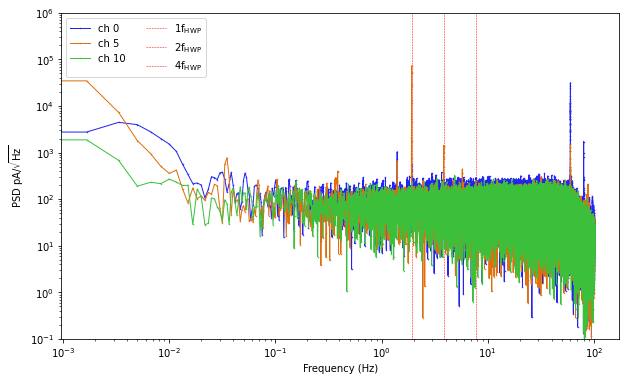

In [66]:
plt.figure(figsize=(10,6))
plt.ylabel('PSD $\mathrm{pA / \sqrt{Hz}}$')
plt.xlabel('Frequency (Hz)')

fhwp = hwp_rate.mean()
plt.vlines(1*fhwp,0,1e11,color='r',lw=0.5,linestyle='--',label=r'1f$_{\mathrm{HWP}}$')
plt.vlines(2*fhwp,0,1e11,color='r',lw=0.5,linestyle='--',label=r'2f$_{\mathrm{HWP}}$')
plt.vlines(4*fhwp,0,1e11,color='r',lw=0.5,linestyle='--',label=r'4f$_{\mathrm{HWP}}$')

#for i in range(aman.dets.count):
for i in [0,5,10]:
    psd = np.sqrt(np.abs(ffts[i])**2/norm_fact)
    plt.loglog(freqs, psd, '.-', markersize=1, lw=1, label='ch ' + str(i))
plt.ylim(1e-1,1e6)
plt.legend(loc=2,ncol=2)
plt.show()

In [67]:
if 'signal_prefilt' in aman_tsat.keys(): aman_tsat.move('signal_prefilt','')
aman_tsat.wrap_new('signal_prefilt', ('dets', 'samps'))
filt = tod_ops.filters.high_pass_sine2(cutoff=1)
aman_tsat.signal_prefilt = np.array(tod_ops.fourier_filter(aman_tsat, filt, detrend=None, signal_name='signal'))

In [68]:
if 'hwp_angle' in aman_tsat.keys(): aman_tsat.move('hwp_angle','')
aman_tsat.wrap('hwp_angle', hwp_angle_tsat)

AxisManager(timestamps[samps], status*[filter_pars], det_info*[dets], iir_params*, signal[dets,samps], primary*[samps], biases[bias_lines,samps], flags*[dets,samps], signal_prefilt[dets,samps], hwp_angle[120233], dets:LabelAxis(817), samps:OffsetAxis(120233), filter_pars:IndexAxis(16), bias_lines:LabelAxis(16))

In [69]:
hwp.extract_hwpss(aman_tsat,mode=3,name='hwpss_ext',signal='signal',bins=3601)

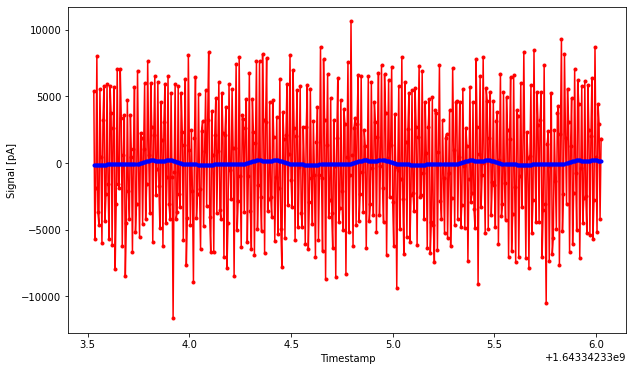

In [70]:
plt.figure(figsize=(10,6))
plt.plot(aman_tsat.timestamps[1000:1500], aman_tsat.signal_prefilt[0][1000:1500],'.-',color='r')
plt.plot(aman_tsat.timestamps[1000:1500], aman_tsat.hwpss_ext[0][1000:1500],'.',color='b')
plt.xlabel('Timestamp')
plt.ylabel('Signal [pA]')
#plt.xlim(aman_tsat.timestamps[0]+1000,aman_tsat.timestamps[0]+1001)
plt.show()

In [71]:
if 'signal_hwpss_subtract' in aman_tsat.keys(): aman_tsat.move('signal_hwpss_subtract','')
aman_tsat.wrap('signal_hwpss_subtract', aman_tsat.signal-aman_tsat.hwpss_ext, [(0,'dets'), (1,'samps')] )
if 'signal_hwpss_subtract_prefilt' in aman_tsat.keys(): aman_tsat.move('signal_hwpss_subtract_prefilt','')
aman_tsat.wrap('signal_hwpss_subtract_prefilt', aman_tsat.signal_prefilt-aman_tsat.hwpss_ext, [(0,'dets'), (1,'samps')] )

AxisManager(timestamps[samps], status*[filter_pars], det_info*[dets], iir_params*, signal[dets,samps], primary*[samps], biases[bias_lines,samps], flags*[dets,samps], signal_prefilt[dets,samps], hwp_angle[120233], hwpss_ext[dets,samps], signal_hwpss_subtract[dets,samps], signal_hwpss_subtract_prefilt[dets,samps], dets:LabelAxis(817), samps:OffsetAxis(120233), filter_pars:IndexAxis(16), bias_lines:LabelAxis(16))

In [72]:
ffts_b, freqs_b = rfft(aman_tsat, resize=None, signal_name='signal')
ffts_a, freqs_a = rfft(aman_tsat, resize=None, signal_name='signal_hwpss_subtract')
tsamp = np.median(np.diff(aman_tsat.timestamps))
norm_fact =  np.sqrt(2)*(1.0/tsamp)*np.sum(np.abs(np.hanning(aman_tsat.samps.count))**2)

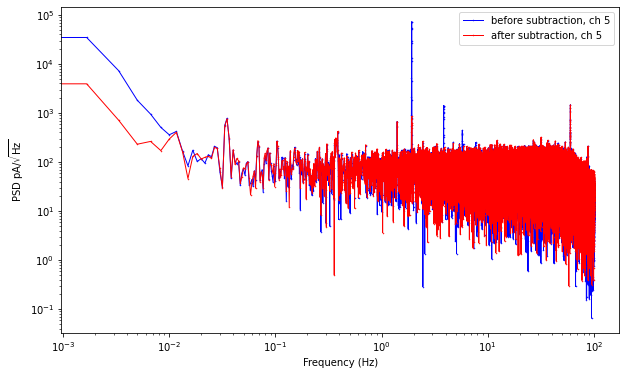

In [73]:
fig = plt.figure(figsize=(10,6))
plt.ylabel('PSD $\mathrm{pA / \sqrt{Hz}}$')
plt.xlabel('Frequency (Hz)')

ch=5
for i in [ch]:
    psd_b = np.sqrt(np.abs(ffts_b[i])**2/norm_fact)
    plt.loglog(freqs_b, psd_b, '.-', markersize=1, color='b',lw=1, label='before subtraction, ch ' + str(i))
for i in [ch]:
    psd_a = np.sqrt(np.abs(ffts_a[i])**2/norm_fact)
    plt.loglog(freqs_a, psd_a, '.-', markersize=1, color='r',lw=1, label='after subtraction, ch ' + str(i))
plt.legend()
plt.show()

## Demodulation 

In [74]:
hwp.demod(aman_tsat)

In [75]:
ffts, freqs = rfft(aman_tsat, resize=None, signal_name='signal')
ffts_demod, freqs_demod = rfft(aman_tsat, resize=None, signal_name='signal_demod')
tsamp = np.median(np.diff(aman_tsat.timestamps))
norm_fact =  np.sqrt(2)*(1.0/tsamp)*np.sum(np.abs(np.hanning(aman_tsat.samps.count))**2)
mask_lpf = np.where(freqs<0.5)

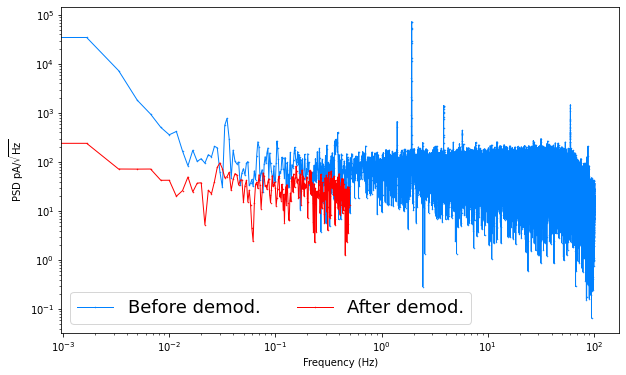

In [76]:
fig = plt.figure(figsize=(10,6))
plt.ylabel('PSD $\mathrm{pA / \sqrt{Hz}}$')
plt.xlabel('Frequency (Hz)')

for i in [5]:
    psd = np.sqrt(np.abs(ffts[i])**2/norm_fact)
    plt.loglog(freqs, psd, '.-', markersize=1, color=cm.jet(i/20),lw=1, label='Before demod.')
    psd_demod = np.sqrt(np.abs(ffts_demod[i])**2/norm_fact)
    plt.loglog(freqs_demod[mask_lpf], psd_demod[mask_lpf], '.-', markersize=1, color='r' ,lw=1, label='After demod.')

plt.legend(ncol=2,fontsize=18)
plt.show()

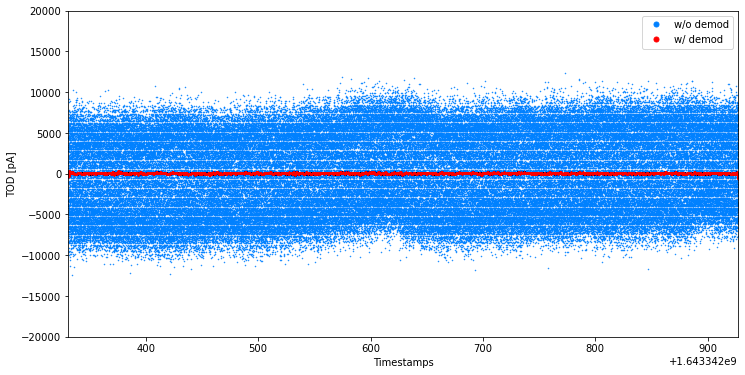

In [77]:
fig = plt.figure(figsize=(12,6))
plt.ylabel('TOD [pA]')
plt.xlabel('Timestamps')
mask = np.zeros_like(aman_tsat.timestamps, np.bool_)
mask[:] = 1
plt.plot(aman_tsat.timestamps[mask], aman_tsat.signal[0][mask] - aman_tsat.signal[0][mask].mean(),  '.', color=cm.jet(5/20), label='w/o demod', markersize=1)
plt.plot(aman_tsat.timestamps[mask], aman_tsat.signal_demod[0][mask] - aman_tsat.signal_demod[0][mask].mean(),  '.r', label='w/ demod', markersize=1)
plt.legend(markerscale=10)
plt.xlim(aman_tsat.timestamps[500],aman_tsat.timestamps[-500])
plt.ylim(-20000,20000)
plt.show()